# Monte Carlo Simulations

This notebook shows some examples of Monte Carlo simulations: (a) the distribution from a GARCH process; (b) the effect of heteroskedasticity on OLS estimates.

## Load Packages and Extra Functions

In [1]:
using Dates, Statistics, Random, LinearAlgebra, Distributions

include("jlFiles/printmat.jl")
include("jlFiles/NWFn.jl")
include("jlFiles/OlsFn.jl")

OlsFn

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))         #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

# Simulating the Distribution of a GARCH(1,1) Variable

The next cell defines a function `GarchSim()` that generates $T$ observations of a variable $u_t$ whose conditional distribution (based on information in $t-1$) is N$(0,\sigma_t^2)$, where $\sigma_t^2$ follows a GARCH(1,1) process:

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

The subsequent cells call on the `GarchSim()` function and plots a histogram of the simulated values. This is repeated for two different values of $\alpha$: a high value and a low value. This strongly affects how different the histogram is from the best fitting $N()$ distributions.

In [3]:
"""
    GarchSim(T,ω,α,β)

Simulate a time series of T residuals from a GARCH(1,1) process
"""
function GarchSim(T,ω,α,β)

    (σ²,u) = [zeros(T) for i=1:2]
    σ²[1]  = ω/(1-α-β)                              #average σ² as starting value
    for t = 2:T
        σ²[t] = ω + α*u[t-1]^2 + β*σ²[t-1]
        u[t]  = sqrt(σ²[t])*randn()
    end

    return u

end

GarchSim

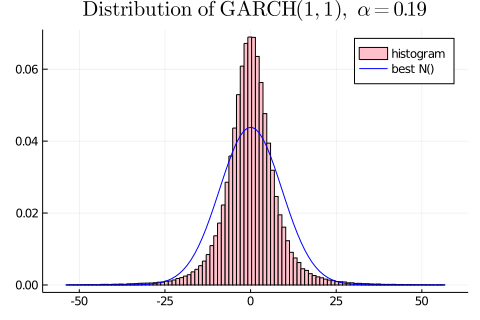

In [4]:
(T,ω,α,β) = (200_000,1,0.19,0.8)                #α=0.19

Random.seed!(123456)                            #to replicate the same random numbers
u = GarchSim(T,ω,α,β)

(qL,qH) = quantile(u,[0.001,0.999])             #quantiles 0.001 and 0.999

uGrid = range(qL,stop=qH,length=101)
pdfNu = pdf.(Normal(mean(u),std(u)),uGrid)

p1 = histogram( u,
                bins = uGrid,
                fillcolor = :pink,
                normalized = true,
                label = "histogram",
                title = L"\mathrm{Distribution \ of \ GARCH(1,1), \ } \alpha =0.19")
plot!(uGrid,pdfNu,color=:blue,label="best N()")
display(p1)

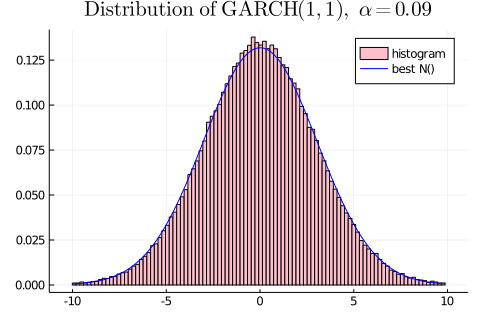

In [5]:
α = 0.09                                            #α=0.09

Random.seed!(123456)
u = GarchSim(T,ω,α,β)

(qL,qH) = quantile(u,[0.001,0.999])

uGrid = range(qL,stop=qH,length=101)
pdfNu = pdf.(Normal(mean(u),std(u)),uGrid)

p1 = histogram( u,
                bins = uGrid,
                fillcolor = :pink,
                normalized = true,
                label = "histogram",
                title = L"\mathrm{Distribution \ of \ GARCH(1,1), \ } \alpha =0.09")
plot!(uGrid,pdfNu,color=:blue,label="best N()")
display(p1)

# Simulating (White's) Heteroskedasticity in OLS

The function `SimOLS` in the next cell simulates data where the residuals in an OLS regression are heteroskedastic, since they are generated as 

$
\epsilon_t = u_t (1+\alpha |f_t|)
$,

where $u_t$ is $N(0,1)$ and $f_t$ is a regressor.

The function estimates the traditional OLS standard errors and also White's standard errors.

The subsequent cell compares the different standard errors in two cases: $\alpha=1$ and $\alpha=0$.

In [6]:
function SimOLS(NSim,T,α)

    (bLS,StdLS,StdWhite) = [fill(NaN,NSim) for i = 1:3]
    for i = 1:NSim
        f = randn(T)
        ϵ = randn(T) .* (1 .+ α*abs.(f))       #heteroskedastic residuals
        y = 1 .+ 0.9*f + ϵ
        x = [f ones(T)]
        (b,u,_) = OlsFn(y,x,0)                 #OLS, point estimates
        bLS[i]  = b[1]
        Sxx         = x'x
        S_W         = (x.*u)'*(x.*u)         
        V_W         = inv(Sxx)'S_W*inv(Sxx)  #Cov(b), White
        StdWhite[i] = sqrt(V_W[1,1])
        V_iid       = inv(Sxx)*var(u)        #OLS, traditional
        StdLS[i]    = sqrt(V_iid[1,1])
    end

    return bLS,StdLS,StdWhite

end

SimOLS (generic function with 1 method)

In [7]:
NSim = 25000           #number of simulated samples
T    = 200             #sample size

α = 1                  #lots of heteroskedasticity
Random.seed!(123456)
(bLS,StdLS,StdWhite) = SimOLS(NSim,T,α)

xut = [std(bLS) mean(StdLS) mean(StdWhite)]
printblue("Std of slope when α=$α")
printTable(xut,["Simulated","OLS","White"],[""])

printred("clearly different results")

Std of slope when α=1
 Simulated       OLS     White
     0.191     0.134     0.185

clearly different results


In [8]:
α = 0                  #no heteroskedasticity
Random.seed!(123456)
(bLS,StdLS,StdWhite) = SimOLS(NSim,T,α)

xut = [std(bLS) mean(StdLS) mean(StdWhite)]
printblue("Std of slope when α=$α")
printTable(xut,["Simulated","OLS","White"],[""])

printred("similar results")

Std of slope when α=0
 Simulated       OLS     White
     0.072     0.071     0.070

similar results
